<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour détection des bennes</b></font></center>
<br>
<br>
<br>

# Intentions

Détecter et entourer les bennes via des bounding box.

# Logs

CV_SEGA_model_objdetect_1 :
- création du notebook
- développement de la fonction de chargement et de redimensionnement
- première modélisation simple pour la prédiction d'une seule BB par image
- ajout des callbacks


# Configuration du notebook

In [1]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "local"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [2]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive')

# Installer

In [4]:
if work_mode == "drive":
    !pip install swifter


# Modules et fonctions

## Import des modules


In [5]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split


E:\programmes\Miniconda3\envs\cv_tflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## La cuisine

In [6]:
# Fonction d'affichage des BB
def show_img_bb (img, x, y, w, h,name):
    
    # Calcul des coordonnées
    x1 = np.abs(x)
    y1 = np.abs(y)
    w = np.abs(w)
    h = np.abs(h)
    x2= x1+w
    y2= y1+h
    
    # Affichage des coordonnées
    print(f"Coordonnées BB {name}")
    print(f'x:{x}',f'y:{y}',f'w:{w}',f'h:{h}')
    print(f'x1:{x1}',f'x2:{x2}',f'y1:{y1}',f'y2:{y2}')
    
    plt.imshow(img)
    plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], "r")
    plt.title("Image : " + name)
#     plt.show()

## Test GPU

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.print(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

No GPU found, CPU mode activated
OrderedDict([('cpu_compiler',
              'C:/Program Files (x86)/Microsoft Visual '
              'Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '64_112'),
             ('cudart_dll_name', 'cudart64_112.dll'),
             ('cudnn_dll_name', 'cudnn64_8.dll'),
             ('cudnn_version', '64_8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False),
             ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'),
             ('nvcuda_dll_name', 'nvcuda.dll')])


# Chargement du dataset

In [8]:
# Lecture des données
if work_mode == "local":
#     data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"
    data_path = "E:/OneDrive/_forge/SEGA/datasets/container"

df = pd.read_csv(data_path + '/df_1_light.csv',index_col=0,converters={'bbox': pd.eval})
df = df.astype({'file_name':'string'})
df["file_name"] = df["file_name"].apply(lambda x: data_path + "/" + x)
display (df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957 entries, 0 to 1956
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1957 non-null   object
 1   bbox       1957 non-null   object
dtypes: object(2)
memory usage: 45.9+ KB


None

,file_name,bbox
0,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[10, 0, 535, 289]"
1,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[10, 0, 535, 289]"
2,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[18, 46, 400, 224]"
3,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[18, 46, 400, 224]"
4,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[1, 51, 703, 606]"


In [9]:
# Filtrage uniquement sur les formats JPEG
df = df[df["file_name"].str.contains(".jpeg")]

<AxesSubplot:>

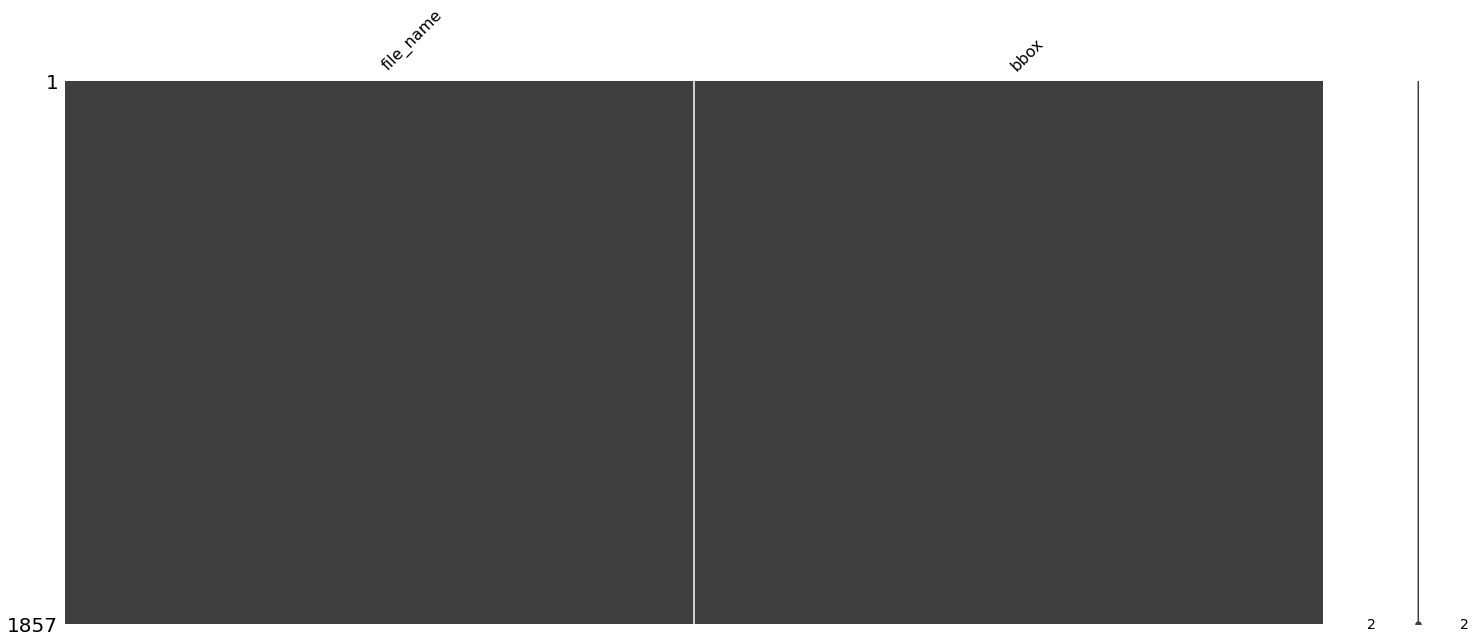

In [10]:
msno.matrix(df)

# Preprocessing

## Séparation

In [11]:
################ Réalisation des sets d'entrainnement et de tests
"""
    taille du set de test => 20 % des données restantes
    random_state => 42
"""

# Séparer la variable explicative de la variable à prédire
X, y = df["file_name"], df["bbox"].apply(lambda x: np.array(x)).to_list()

# X, X_test, y, y_test  = train_test_split(X, y, test_size=0.1,random_state = 42)
# X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.1,random_state = 42)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.1,random_state = 42)

## Fonction de chargement

In [13]:
# Fonction de chargement des images via un numpy array ou un chemin
@tf.function
def magic_loader (X, y, fromfile = False, norm = True, resize = None):   
    
    # ==== Chargement de l'image
    if fromfile == True:
        image = tf.io.read_file(X, name=None)
        image = tf.io.decode_image(image,channels=3,expand_animations=False)     
     
    else:
        image = tf.convert_to_tensor(X)

    # ==== Normalisation    
    if norm :
        image = tf.divide(image, 255)
    
    # ==== Redimensionnement  
    if resize!= None:
        # Récupération de l'ancienne taille de l'image
        old_size = tf.shape(image)[:2]

        # Définition de la taille cible de l'image
        img_size = tf.constant(resize)

        # Redimensionnement
        image = tf.image.resize(image,
                             img_size,
                             method='nearest',
                             preserve_aspect_ratio=False,
                             antialias=False,
                             name=None)
        
        # Calcul du ratio de redimensionnement pour adapter les bounding boxs
        ratio = tf.math.divide(img_size,old_size)
        ratio = tf.cast(ratio, dtype="float32")
        

        
        # Redimensionnement des bounding boxs
        y = tf.convert_to_tensor(y)
        y = tf.cast(y, dtype="float32")
        x_sized = y[0]*ratio[1]
        y_sized = y[1]*ratio[0]
        w_sized = y[2]*ratio[1]
        h_sized = y[3]*ratio[0]
        y_new = tf.stack([x_sized,y_sized,w_sized,h_sized],0)

    else:
        y_new = y

    return image, y_new 




==== Avant ====
(720, 1520, 3)
[419, 175, 535, 456]
Coordonnées BB E:/OneDrive/_forge/SEGA/datasets/container/01746.jpeg
x:419 y:175 w:535 h:456
x1:419 x2:954 y1:175 y2:631


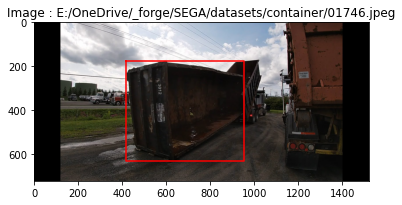

==== Après ====
(128, 128, 3)
tf.Tensor([35.28421  31.111113 45.052635 81.066666], shape=(4,), dtype=float32)
Coordonnées BB E:/OneDrive/_forge/SEGA/datasets/container/01746.jpeg
x:35.284210205078125 y:31.111112594604492 w:45.052635192871094 h:81.06666564941406
x1:35.284210205078125 x2:80.33684539794922 y1:31.111112594604492 y2:112.17778015136719


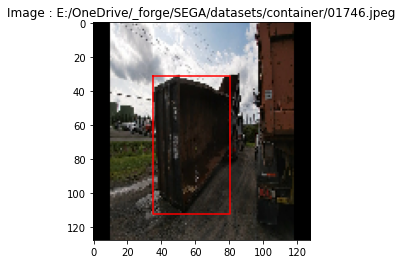

In [14]:
# ================================================================================================
# Définition de l'image pour test
i = random.choices(list(df.index), k=1)[0]
img_path = df.loc[i,"file_name"]

# ================================================================================================
# Test de la fonction
image = plt.imread(img_path)

print("==== Avant ====")
print(image.shape)
print(df.loc[i,"bbox"])
show_img_bb (image, df.loc[i,"bbox"][0], df.loc[i,"bbox"][1], df.loc[i,"bbox"][2], df.loc[i,"bbox"][3], df.loc[i,"file_name"] )
plt.show()

# Application de la fonction fonctions
image_new, y_new = magic_loader(img_path, df.loc[i,"bbox"], fromfile = True, norm = True, resize = (128,128))

print("==== Après ====")
print(image_new.shape)
print(y_new)
show_img_bb (image_new, y_new[0], y_new[1], y_new[2], y_new[3], df.loc[i,"file_name"] )
plt.show()

## Générateur de données

In [15]:
batch_size = 8
imgRsize = (256, 256)
AUTO = tf.data.experimental.AUTOTUNE

# Train
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train)).map(lambda x, y : magic_loader(x,
                                                                                   y,
                                                                                   fromfile = True,
                                                                                   norm = True,
                                                                                   resize = imgRsize
                                                                                  ), num_parallel_calls=-1
                                                       )\
                                                    .batch(batch_size,drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# Test
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(len(X_test)).map(lambda x, y : magic_loader(x,
                                                                                y,
                                                                                fromfile = True,
                                                                                norm = True,
                                                                                resize = imgRsize
                                                                               ))\
                                                    .batch(batch_size,drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# # Val
# dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# dataset_val = dataset_test.shuffle(len(X_val)).map(lambda x, y : magic_loader(x,
#                                                                               y,
#                                                                               fromfile = True,
#                                                                               norm = True,
#                                                                               resize = imgRsize
#                                                                              ))\
#                                                     .batch(batch_size,drop_remainder=True)\
#                                                     .cache()\
#                                                     .prefetch(AUTO)\
#                                                     .repeat(-1)


Coordonnées BB X
x:145.5518341064453 y:19.809524536132812 w:81.3377914428711 h:67.04762268066406
x1:145.5518341064453 x2:226.88961791992188 y1:19.809524536132812 y2:86.85714721679688


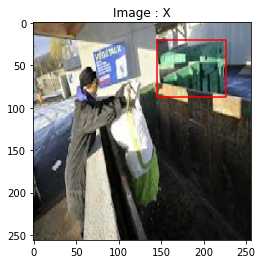

Coordonnées BB X
x:0.1846153885126114 y:21.415386199951172 w:254.95384216308594 h:234.09231567382812
x1:0.1846153885126114 x2:255.13845825195312 y1:21.415386199951172 y2:255.50770568847656


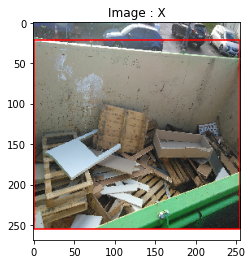

Coordonnées BB X
x:0.2666666805744171 y:92.80000305175781 w:196.2666778564453 h:150.18667602539062
x1:0.2666666805744171 x2:196.53334045410156 y1:92.80000305175781 y2:242.98667907714844


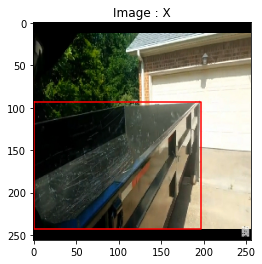

Coordonnées BB X
x:86.25230407714844 y:44.5217399597168 w:99.83999633789062 h:77.69043731689453
x1:86.25230407714844 x2:186.09230041503906 y1:44.5217399597168 y2:122.21217346191406


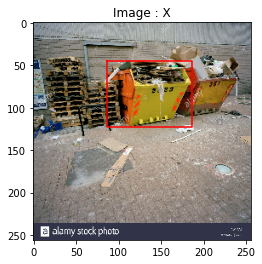

Coordonnées BB X
x:16.360902786254883 y:86.23158264160156 w:225.20301818847656 h:164.3789520263672
x1:16.360902786254883 x2:241.5639190673828 y1:86.23158264160156 y2:250.61053466796875


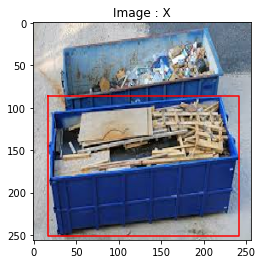

Coordonnées BB X
x:0.3199999928474426 y:23.534709930419922 w:255.67999267578125 h:232.4652862548828
x1:0.3199999928474426 x2:256.0 y1:23.534709930419922 y2:256.0


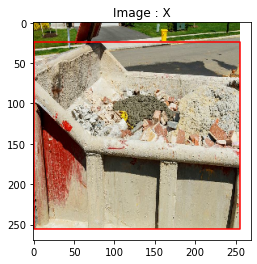

Coordonnées BB X
x:18.559999465942383 y:54.400001525878906 w:97.27999877929688 h:136.8000030517578
x1:18.559999465942383 x2:115.83999633789062 y1:54.400001525878906 y2:191.20001220703125


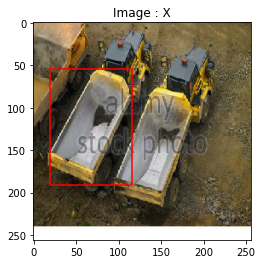

Coordonnées BB X
x:2.2164502143859863 y:56.109588623046875 w:251.5670928955078 h:167.15980529785156
x1:2.2164502143859863 x2:253.78353881835938 y1:56.109588623046875 y2:223.26939392089844


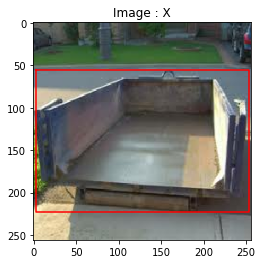

In [16]:
# Visualisation des sorties du générateur train

X_t, y_t = next(iter(dataset_train))

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0], bbox[1], bbox[2], bbox[3], "X" )
    plt.show()

In [17]:
# Définition d'un générateur python
def generator(dataset):
    iterator = iter(dataset)
    while True:
        X, y = next(iterator)
        yield X, y

# Définition du générateur final.
gen_train = generator(dataset_train)
gen_test = generator(dataset_test)

# Modélisation

## Partrie encoder

In [18]:
from tensorflow.keras.applications import EfficientNetB0

# Load the model efficientNet
efficientNet = EfficientNetB0(include_top=False, input_shape=(imgRsize[0],imgRsize[1],3))

# Freeze the blackbone
for layer in efficientNet.layers:
    layer.trainable = False

## Partie régression

In [19]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

## Fonction de perte

In [20]:
def coord_loss(y_true, y_pred):
    
    # Conversion en tenseurs
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    # Répartition des valeurs
    xpred = y_pred[:,0]
    xtrue = y_true[:,0]
    ypred = y_pred[:,1]
    ytrue = y_true[:,1]
    wpred = y_pred[:,2]
    wtrue = y_true[:,2]
    hpred = y_pred[:,3]
    htrue = y_true[:,3]
    
    # Calcul des différents membres de la formule
    a = tf.math.square(xpred - xtrue)
    b = tf.math.square(ypred - ytrue)
    c = tf.math.square(tf.math.sqrt(tf.math.abs(wpred))-tf.math.sqrt(wtrue))
    d = tf.math.square(tf.math.sqrt(tf.math.abs(hpred))-tf.math.sqrt(htrue))

    return tf.reduce_mean((a + b + c + d), axis=-1)


In [ ]:
# Fonction d'affichage des BB
def show_img_bb (img, x, y, w, h,name):
    
    # Calcul des coordonnées
    x1 = np.abs(x)
    y1 = np.abs(y)
    w = np.abs(w)
    h = np.abs(h)
    x2= x1+w
    y2= y1+h
    
    # Affichage des coordonnées
    print(f"Coordonnées BB {name}")
    print(f'x:{x}',f'y:{y}',f'w:{w}',f'h:{h}')
    print(f'x1:{x1}',f'x2:{x2}',f'y1:{y1}',f'y2:{y2}')
    
    plt.imshow(img)
    plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], "r")
    plt.title("Image : " + name)
#     plt.show()

In [ ]:
def metric_iou(y_true, y_pred):
    p_object = tf.cast(y_true[:,0], tf.float32)
    y_true = tf.cast(y_true[:, 1:], tf.float32)
    y_pred = tf.cast(y_pred[:, 1:], tf.float32)
    x1, y1, w1, h1 = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]
    
    x2, y2, w2, h2 = tf.abs(y_pred[:,0]), tf.abs(y_pred[:,1]), tf.abs(y_pred[:,2]), tf.abs(y_pred[:,3])
    
    # Compute xA, yA, xB, yB
    xA = tf.maximum(x1-w1/2, x2-w2/2)
    yA = tf.maximum(y1-h1/2, y2-h2/2)
    xB = tf.minimum(x1+w1/2, x2+w2/2)
    yB = tf.minimum(y1+h1/2, y1+h1/2)
    
    # Intersection area
    intersect_area = tf.nn.relu(xB - xA) * tf.nn.relu(yB - yA)
    # or 
    # intersect_area = tf.maximum(xB - xA, 0) * tf.maximum(yB - yA, 0)
    
    # Union area
    true_area = y_true[:,2] * y_true[:,3]
    pred_area = tf.abs(y_pred[:,2] * y_pred[:,3])
    union_area = pred_area + true_area - intersect_area
    
    # Compute the real IoU
    return tf.reduce_sum(p_object*intersect_area / union_area)/tf.reduce_sum(p_object)

## Compilation

In [21]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss=coord_loss,
              optimizer=Adam(1e-3),
              metrics = "accuracy"
             )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

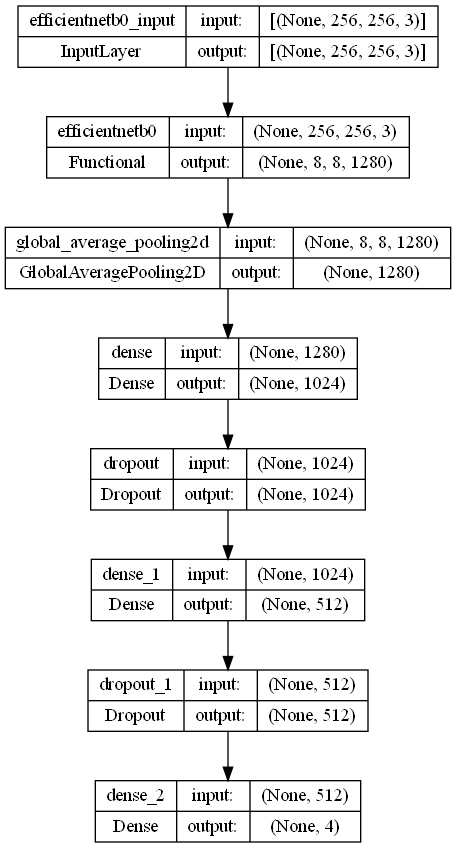

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Callbacks

In [25]:
from tensorflow.keras import callbacks

In [26]:
# Callback pour la gestion du learning rate
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 3 == 0:
        return learning_rate * 0.1
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule=decreasinglrUpdate, verbose=1)

In [27]:
# Réduction du lr sur un plateau
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=5,
                                         verbose=2,
                                         mode='min')

In [28]:
# Callback pour l'arrêt anticipé si les perfos ne s'améliorent pas.
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

## Entrainement

In [29]:
nb_epochs = 10
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping,lr_plateau]
                   )

Epoch 1/10
208/208 [==============================] - 101s 457ms/step - loss: 4787.8916 - accuracy: 0.2133 - val_loss: 4208.3540 - val_accuracy: 0.2826 - lr: 0.0010
Epoch 2/10
208/208 [==============================] - 90s 434ms/step - loss: 4540.0938 - accuracy: 0.4261 - val_loss: 4246.4795 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 3/10
208/208 [==============================] - 92s 442ms/step - loss: 4548.2061 - accuracy: 0.5751 - val_loss: 4237.9619 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 4/10
208/208 [==============================] - 88s 425ms/step - loss: 4528.2222 - accuracy: 0.5853 - val_loss: 4231.8696 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 5/10
208/208 [==============================] - 89s 426ms/step - loss: 4508.5420 - accuracy: 0.5853 - val_loss: 4251.8721 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 6/10
208/208 [==============================] - ETA: 0s - loss: 4505.6440 - accuracy: 0.5865
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
208

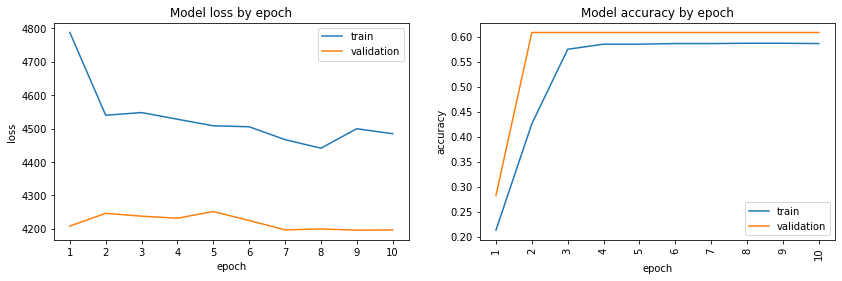

In [30]:
# Config
first_var = 'loss'
second_var = 'accuracy'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 90)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Optim

In [ ]:
def load_image(X,img_size,y,dataAugmentation = False, fromfile = False, nb_chanel = 3):
    
    if fromfile == True:
        im = tf.io.read_file(X)
        im = tf.image.decode_png(im, channels=nb_chanel)
        img,ratio = resize_img(im,img_size)
    else:
        img,ratio = resize_img(X,img_size)
    
    x1 = y[0]*ratio[1]
    x2 = y[2]*ratio[1]
    y1 = y[1]*ratio[0]
    y2 = y[3]*ratio[0]
    
    new_y = tf.stack([x1,x2,y1,y2],0)
    
    if dataAugmentation :
        img,new_y = get_random_transform(img,new_y)
    
    return [img,new_y]

In [ ]:
A intégrer par la suite mais sans le H flip !!!!!
def get_random_transform(X,y):
        
        def V_Flip(X,y):
            X =tf.image.flip_up_down(X)
            new_y = X.shape[1] - y[2:]
            new_y = tf.stack([y[0],y[1],new_y[0],new_y[1]],0)
            return X,new_y
        
        def H_Flip(X,y):
            X = tf.image.flip_left_right(X)
            new_x = X.shape[0] - y[:2]
            new_y = tf.stack([new_x[0],new_x[1],y[2], y[3]],0)
            return X,new_y
        
        def Identity(X,y):
            return X,y
        
        def GreyScale(X,y):
            X = tf.image.rgb_to_grayscale(X)
            X = tf.stack([X,X,X],2)[:,:,:,0]
            return X,y
        
        # Utilisation des outils random de tf pour bien que ca fonctionne avec le format des tenseurs symboliques
        
        p = tf.random.uniform(shape = [1], minval=0, maxval=5, dtype=tf.dtypes.int32)
        chanel_nb = X.shape[-1]
                
        X,y = tf.cond(p == 0 ,lambda: Identity(X,y), lambda: Identity(X,y))
        X,y = tf.cond(p == 1 ,lambda: H_Flip(X,y), lambda: Identity(X,y))
        X,y = tf.cond(p == 2 ,lambda: V_Flip(X,y), lambda: Identity(X,y))
        if chanel_nb ==3:
            X,y = GreyScale(X,y)
        else:
            X,y = Identity(X,y)
#         X,y = tf.cond(((p == 3)&( chanel_nb ==3)) ,lambda: GreyScale(X,y), lambda: Identity(X,y))
        
        return X,y

In [ ]:
Ajouter un le set de bâtiments pour mieux entrainner
Intégrer la data augmentation dans la fonction de chargement
Traiter le cas où j'ai plusieurs BB sur lamême image
Est-ce qu'il ne faut pas remélanger le dataset ?
Pour les landmarks / keypoints on utilise un algo qui détecte la zone puis qui donne les landmarks à partir de la zone à traiter.
Object detection -> Yolo est top
Attention, il semble y avoir des images dupliquées dans le dataset, regarder ça dans l'explo
Mise en place d'un LR sinus